In [1]:
from driver.MongoDriver import MongoDriver
import util.Constants as const
from service.DataPreparationHandler import get_data
from util.PandasUtils import PandasUtils
import DisplayHelper
from DisplayHelper import *
from pprint import PrettyPrinter
from util.DataPreparationUtils import *
from stubutils.StubUtils import open_file
import pandas
from datetime import datetime
from scipy import stats
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.preprocessing import OneHotEncoder as ohe
import xgboost as xgb

D:\Anaconda3\envs\dlwin36\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

In [5]:
db_instance = MongoDriver.get_instance().get_db_instance(const.DB_INSTANCE)
data = get_data(db_instance, 'normalized_data')
dataframe = PandasUtils.get_dataframe(data, const.JSON_STRUCTURE)

In [6]:
#Create delta columns for fields "from" and "to"
dataframe['search_volume'] = (dataframe['search_volume_to'] + dataframe['search_volume_from'])/2
dataframe['search_milleage'] = (dataframe['search_milleage_to'] + dataframe['search_milleage_from'])/2
dataframe['search_price'] = (dataframe['search_price_to'] + dataframe['search_price_from'])/2
dataframe['search_year'] = (dataframe['search_year_to'] + dataframe['search_year_from'])/2

In [7]:
for column in const.NUMERIC_COLUMNS_REQUIRE_ANALYSIS:
        quartiles = get_percentiles_for_numeric_column(dataframe,column)
        dataframe.loc[ dataframe[column] <= quartiles['values'][1], column] = 0
        dataframe.loc[(dataframe[column] > quartiles['values'][1]) & (dataframe[column] <= quartiles['values'][2]), column] = 1
        dataframe.loc[(dataframe[column] > quartiles['values'][2]) & (dataframe[column] <= quartiles['values'][3]), column]   = 2
        dataframe.loc[ dataframe[column] > quartiles['values'][3], column] = 3
        dataframe[column] = dataframe[column].astype(int)

In [6]:
dataframe['search_model'] = dataframe.apply(lambda row: get_id_by_make_name(row['search_model']),axis=1).astype(int)
dataframe['search_rigion'] = dataframe.apply(lambda row: get_id_by_region_name(row['search_rigion']),axis=1).astype(int)
dataframe['search_city'] = dataframe.apply(lambda row: get_id_by_city_name(row['search_city']),axis=1).astype(int)
dataframe['search_country'] = dataframe.apply(lambda row: get_id_by_name_simple(const.COUNTRY_ID_MAPPING_JSON_ROUTE, row['search_country']),axis=1).astype(int)
dataframe['search_marka'] = dataframe.apply(lambda row: get_id_by_name_simple(const.MODELS_ID_MAPPING_JSON_ROUTE, row['search_marka']),axis=1).astype(int)
dataframe['search_wheel'] = dataframe.apply(lambda row: get_id_by_name_simple(const.WHEELS_ID_MAPPING_JSON_ROUTE, row['search_wheel']),axis=1).astype(int)
dataframe['search_body'] = dataframe.apply(lambda row: get_id_by_name_simple(const.BODIES_ID_MAPPING_JSON_ROUTE, row['search_body']),axis=1).astype(int)
dataframe['search_transmission'] = dataframe.apply(lambda row: get_id_by_name_simple(const.TRANSMISSIONS_ID_MAPPING_JSON_ROUTE, row['search_transmission']),axis=1).astype(int)

In [8]:
for column_name in const.DATE_COLUMNS:
        dataframe[column_name] = dataframe.apply(lambda row: get_season_by_utcdate(row[column_name]),axis=1)

In [9]:
#Drop unhandled columns
for column in const.COLUMNS_TO_DROP:
    dataframe = dataframe.drop(column, axis=1)
    
# dataframe = dataframe.drop("search_city", axis=1)
#dataframe = dataframe.drop("search_rigion", axis=1)
dataframe = dataframe.drop("search_model", axis=1)
#dataframe = dataframe.drop("search_year", axis=1)
#dataframe = dataframe.drop("search_volume", axis=1)
#dataframe = dataframe.drop("search_milleage", axis=1)
#dataframe = dataframe.drop("search_price", axis=1)
#dataframe = dataframe.drop("search_year", axis=1)

In [10]:
dataframe["a"] = dataframe.apply(lambda row: (row['search_volume'] + 1)/(row['search_milleage']+1),axis=1).astype(int)
dataframe["b"] = dataframe.apply(lambda row: (row['search_volume'] + 1)/(row['search_price']+1),axis=1).astype(int)
dataframe["c"] = dataframe.apply(lambda row: (row['search_volume'] + 1)/(row['search_year']+1),axis=1).astype(int)
dataframe["d"] = dataframe.apply(lambda row: (row['search_milleage'] + 1)/(row['search_volume']+1),axis=1).astype(int)
dataframe["f"] = dataframe.apply(lambda row: (row['search_milleage'] + 1)/(row['search_price']+1),axis=1).astype(int)
dataframe["e"] = dataframe.apply(lambda row: (row['search_milleage'] + 1)/(row['search_year']+1),axis=1).astype(int)

In [10]:
X_data = dataframe.drop("search_marka", axis=1)          # data: Features
Y_data = dataframe["search_marka"]                       # data: Labels
for f in X_data.columns: 
    if X_data[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder() 
        lbl.fit(list(X_data[f].values)) 
        X_data[f] = lbl.transform(list(X_data[f].values))
#split data into random "train" and "test" set 
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=0)
X_train = X_train.drop('user_id', axis=1)

In [ ]:
X_test_ref = X_test.drop('user_id', axis=1)
xg_train = xgb.DMatrix(X_train, label=Y_train)
xg_test = xgb.DMatrix(X_test_ref, label=Y_test)
# setup parameters for xgboost
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.1
param['max_depth'] = 4
param['silent'] = 1
param['nthread'] = 4
param['subsample'] = 0.6
# param['min_child_weight'] = 100
param['num_class'] = 150

res = xgb.cv(param, xg_train, nfold = 5, num_boost_round = 100, stratified = True, verbose_eval = True)

In [ ]:
X_test_ref = X_test.drop('user_id', axis=1)
xg_train = xgb.DMatrix(X_train, label=Y_train)
xg_test = xgb.DMatrix(X_test_ref, label=Y_test)
# setup parameters for xgboost
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.1
param['max_depth'] = 4
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = 150
watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 3000
bst = xgb.train(param, xg_train, num_round, watchlist)
# get prediction
pred = bst.predict(xg_test, ntree_limit=bst.best_iteration)
# error_rate = np.sum(pred != Y_test) / Y_test.shape[0]
print('Accuracy score = {}'.format(accuracy_score(Y_test, pred)))

In [18]:
import xgboost as xgb
param_dist = {'n_estimators':7, 'nthread':22, 'max_depth':7}
xg = xgb.XGBClassifier()
d1 = datetime.now()
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=0)
X_train = X_train.drop('user_id', axis=1)
for i in range(1,60):
    X_inner_train, X_inner_test, Y_inner_train, Y_inner_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=0)
    X_inner_train = X_inner_train.drop('user_id', axis=1)
    xg.fit(X_inner_train, Y_inner_train, verbose=True)
d2 = datetime.now()
delta = d2 - d1
print "training finished in " + str(delta.seconds) + " seconds"
X_test_ref = X_test.drop('user_id', axis=1)
Y_pred  = xg.predict(X_test_ref)
accuracy_score(Y_test, Y_pred)

training finished in 331 seconds


0.016666666666666666

In [9]:
for f in X_train.columns: 
    if X_train[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder() 
        lbl.fit(list(X_train[f].values)) 
        X_train[f] = lbl.transform(list(X_train[f].values))
for f in X_test.columns: 
    if X_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder() 
        lbl.fit(list(X_test[f].values)) 
        X_test[f] = lbl.transform(list(X_test[f].values))

In [17]:
import xgboost as xgb
# Support Vector Machines
d1 = datetime.now()
param_dist = {'n_estimators':355, 'nthread':22, 'max_depth':7}
xg = xgb.XGBClassifier()
xg.fit(X_train, Y_train, verbose=True)
d2 = datetime.now()
delta = d2 - d1
print "training finished in " + str(delta.seconds) + " seconds"
X_test_ref = X_test.drop('user_id', axis=1)
Y_pred  = xg.predict(X_test_ref)

submission = pd.DataFrame({
         "user_id": X_test["user_id"],
         "search_marka": Y_pred
     })
submission.to_csv('resource/results_XGB.csv', index=False)
accuracy_score(Y_test, Y_pred)

training finished in 3 seconds


0.016666666666666666

In [9]:

dataframe = pandas.get_dummies(dataframe, columns=["search_rigion", "search_country", "search_city", "search_body", "search_transmission", "search_wheel"], 
                   prefix=["rigion", "country", "city","body","transmission","wheel"])

In [ ]:
dataframe['search_marka'] = dataframe.apply(lambda row: get_id_by_name_simple(const.MODELS_ID_MAPPING_JSON_ROUTE, row['search_marka']),axis=1)

In [44]:
import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from keras import optimizers

In [11]:
# fix random seed for reproducibility
seed = 50
numpy.random.seed(seed)

In [3]:
# load dataset
dataframe = pandas.read_csv("test.csv", header=None)
dataset = dataframe.values
X = dataset[:,0:4].astype(float)
Y = dataset[:,4]

In [16]:
X_data = dataframe.drop("search_marka", axis=1)          # data: Features
Y_data = dataframe["search_marka"]                       # data: Labels

X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=0)

X = X_train.drop(['user_id'], axis=1).values
X_test = X_test.drop(['user_id'], axis=1).values
Y = Y_train.values
Y_test = Y_test.values

# encode class values as integers
uniques_train, ids_train = np.unique(Y_train, return_inverse=True)
uniques_test, ids_test = np.unique(Y_test, return_inverse=True)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_train = np_utils.to_categorical(ids_train, len(Y_data.unique()))
# convert integers to dummy variables (i.e. one hot encoded)
dummy_test = np_utils.to_categorical(ids_test, len(Y_data.unique()))

In [122]:
set(uniques_train) - set(uniques_test)

set()

In [ ]:
uniques_test

In [58]:
from keras.callbacks import Callback
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current > self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True
callbacks = [
    EarlyStoppingByLossVal(monitor='val_acc', value=0.92, verbose=1),
    # EarlyStopping(monitor='val_loss', patience=2, verbose=0),
]

In [55]:
# define baseline model
def baseline_model():
    model = Sequential()
    
    model.add(Dense(X.shape[1]-1, input_dim=X.shape[1], activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(X.shape[1]-2, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(X.shape[1]-1, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(X.shape[1]-1, input_dim=X.shape[1], activation='relu'))
#     model.add(Dense(8, input_dim=4, activation='relu'))
    model.add(Dense(len(dataframe['search_marka'].unique()), activation='softmax'))
#     model.add(Dense(3, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [108]:
from numpy import argmax
dummy = numpy.take(Y_data.unique(), numpy.argmax(dummy_y_test,1))
dummy

array(['Opel', 'Ford', 'Skoda', ..., 'Yugo', 'Cadillac', 'Autobianchi'], dtype=object)

In [130]:
Y_test

array(['Saipa', 'Austin', 'SsangYong', ..., 'Saturn', 'Jeep', 'Toyota'], dtype=object)

In [112]:
y_code = np_utils.to_categorical(ids, len(uniques))

In [127]:
pred = uniques_test[dummy_train.argmax(1)]
accuracy_score(Y_train, pred)

1.0

In [106]:
encoded_Y

array([ 92,   6, 100, ...,  94,  55, 108], dtype=int64)

In [ ]:
Y_train

In [42]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=20, batch_size=200, verbose=1)

In [43]:
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [60]:
model = baseline_model()
model.fit(X, dummy_train, batch_size=50, epochs=3000, validation_data=(X_test, dummy_test), callbacks=callbacks)

Train on 7999 samples, validate on 2000 samples
Epoch 1/3000
7999/7999 [==============================] - 279s - loss: 4.8872 - acc: 0.0080 - val_loss: 4.8828 - val_acc: 0.0065
Epoch 2/3000
7999/7999 [==============================] - 167s - loss: 4.6773 - acc: 0.0180 - val_loss: 4.2011 - val_acc: 0.0335
Epoch 3/3000
7999/7999 [==============================] - 161s - loss: 3.8953 - acc: 0.0568 - val_loss: 3.5514 - val_acc: 0.0810
Epoch 4/3000
7999/7999 [==============================] - 163s - loss: 3.4058 - acc: 0.1046 - val_loss: 3.0176 - val_acc: 0.1625
Epoch 5/3000
7999/7999 [==============================] - 164s - loss: 2.8697 - acc: 0.1979 - val_loss: 2.6759 - val_acc: 0.2460
Epoch 6/3000
7999/7999 [==============================] - 160s - loss: 2.3864 - acc: 0.3022 - val_loss: 2.1149 - val_acc: 0.3890
Epoch 7/3000
7999/7999 [==============================] - 164s - loss: 1.9865 - acc: 0.3905 - val_loss: 1.8500 - val_acc: 0.4390
Epoch 8/3000
7999/7999 [=========================

7999/7999 [==============================] - 153s - loss: 0.0589 - acc: 0.9799 - val_loss: 1.0458 - val_acc: 0.8400
Epoch 64/3000
7999/7999 [==============================] - 153s - loss: 0.0864 - acc: 0.9741 - val_loss: 0.9498 - val_acc: 0.8480
Epoch 65/3000
7999/7999 [==============================] - 152s - loss: 0.0601 - acc: 0.9809 - val_loss: 1.0026 - val_acc: 0.8420
Epoch 66/3000
7999/7999 [==============================] - 154s - loss: 0.0675 - acc: 0.9787 - val_loss: 0.9950 - val_acc: 0.8415
Epoch 67/3000
7999/7999 [==============================] - 153s - loss: 0.0492 - acc: 0.9840 - val_loss: 0.9604 - val_acc: 0.8475
Epoch 68/3000
7999/7999 [==============================] - 153s - loss: 0.0613 - acc: 0.9807 - val_loss: 0.9687 - val_acc: 0.8460
Epoch 69/3000
7999/7999 [==============================] - 154s - loss: 0.0735 - acc: 0.9771 - val_loss: 0.9645 - val_acc: 0.8450
Epoch 70/3000
7999/7999 [==============================] - 153s - loss: 0.0610 - acc: 0.9812 - val_loss:

ResourceExhaustedError: OOM when allocating tensor with shape[3639,3638]
	 [[Node: mul_523 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](sub_315, gradients_12/dense_62/MatMul_grad/MatMul_1)]]

Caused by op 'mul_523', defined at:
  File "D:\Anaconda3\envs\dlwin36\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "D:\Anaconda3\envs\dlwin36\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "D:\Anaconda3\envs\dlwin36\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "D:\Anaconda3\envs\dlwin36\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "D:\Anaconda3\envs\dlwin36\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "D:\Anaconda3\envs\dlwin36\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "D:\Anaconda3\envs\dlwin36\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "D:\Anaconda3\envs\dlwin36\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "D:\Anaconda3\envs\dlwin36\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "D:\Anaconda3\envs\dlwin36\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "D:\Anaconda3\envs\dlwin36\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "D:\Anaconda3\envs\dlwin36\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "D:\Anaconda3\envs\dlwin36\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "D:\Anaconda3\envs\dlwin36\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "D:\Anaconda3\envs\dlwin36\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "D:\Anaconda3\envs\dlwin36\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "D:\Anaconda3\envs\dlwin36\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "D:\Anaconda3\envs\dlwin36\lib\site-packages\IPython\core\interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "D:\Anaconda3\envs\dlwin36\lib\site-packages\IPython\core\interactiveshell.py", line 2808, in run_ast_nodes
    if self.run_code(code, result):
  File "D:\Anaconda3\envs\dlwin36\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-3682969d6ad7>", line 2, in <module>
    model.fit(X, dummy_train, batch_size=50, epochs=3000, validation_data=(X_test, dummy_test), callbacks=callbacks)
  File "D:\Anaconda3\envs\dlwin36\lib\site-packages\keras\models.py", line 870, in fit
    initial_epoch=initial_epoch)
  File "D:\Anaconda3\envs\dlwin36\lib\site-packages\keras\engine\training.py", line 1490, in fit
    self._make_train_function()
  File "D:\Anaconda3\envs\dlwin36\lib\site-packages\keras\engine\training.py", line 1014, in _make_train_function
    self.total_loss)
  File "D:\Anaconda3\envs\dlwin36\lib\site-packages\keras\optimizers.py", line 422, in get_updates
    m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
  File "D:\Anaconda3\envs\dlwin36\lib\site-packages\tensorflow\python\ops\math_ops.py", line 838, in binary_op_wrapper
    return func(x, y, name=name)
  File "D:\Anaconda3\envs\dlwin36\lib\site-packages\tensorflow\python\ops\math_ops.py", line 1061, in _mul_dispatch
    return gen_math_ops._mul(x, y, name=name)
  File "D:\Anaconda3\envs\dlwin36\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 1377, in _mul
    result = _op_def_lib.apply_op("Mul", x=x, y=y, name=name)
  File "D:\Anaconda3\envs\dlwin36\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "D:\Anaconda3\envs\dlwin36\lib\site-packages\tensorflow\python\framework\ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "D:\Anaconda3\envs\dlwin36\lib\site-packages\tensorflow\python\framework\ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[3639,3638]
	 [[Node: mul_523 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](sub_315, gradients_12/dense_62/MatMul_grad/MatMul_1)]]


In [ ]:
score = model.evaluate(X_test, dummy_y_test, batch_size=32)

print('Accuracy score = {}'.format(score))

In [54]:
pred = model.predict(X_test)
corrected_pred = uniques_test[numpy.round(pred).argmax(1)]
accuracy_score(Y_test, corrected_pred)

0.873

In [20]:
round_pred = numpy.round(pred)
count_0 = 0
count_1 = 0
for i in numpy.nditer(round_pred):
    if i == 1:
        count_1 = count_1 + 1
    else:
        count_0 = count_0 + 1
print("Count of 1 = {}".format(count_1))
print("Count of 0 = {}".format(count_0))


Count of 1 = 1979
Count of 0 = 262021


In [ ]:
import xgboost as xgb
# Support Vector Machines
for i in range(1,150):
    for j in range(1,15):
        param_dist = {'n_estimators':i, 'nthread':22, 'max_depth':j}
        xg = xgb.XGBClassifier(**param_dist)
        xg.fit(X_train, Y_train, verbose=True)
        X_test_ref = X_test.drop('user_id', axis=1)
        Y_pred  = xg.predict(X_test_ref)
        print "accuracy {} with parameters {}".format(accuracy_score(Y_test, Y_pred), param_dist)

In [ ]:
X_test_ref = X_test.drop('user_id', axis=1)
xg_train = xgb.DMatrix(X_train.values, label=Y_train.values)
xg_test = xgb.DMatrix(X_test_ref.values, label=Y_test)
# setup parameters for xgboost
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.1
param['max_depth'] = 6
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = len(dataframe['search_marka'].unique())

watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 5
bst = xgb.train(param, xg_train, num_round, watchlist)
# get prediction
pred = bst.predict(xg_test)
error_rate = np.sum(pred != Y_test) / Y_test.shape[0]
print('Test error using softmax = {}'.format(error_rate))

In [27]:
# Support Vector Machines
xg = rfc()
d3 = datetime.now()
xg.fit(X_train, Y_train)
d4 = datetime.now()
delta1 = d4 - d3
print "training finished in " + str(delta1.seconds) + " seconds"
X_test_rfc_ref = X_test.drop('user_id', axis=1)
Y_rfc_pred  = xg.predict(X_test_rfc_ref)

submission_rfc = pd.DataFrame({
         "user_id": X_test["user_id"],
         "search_marka": Y_rfc_pred
     })
submission_rfc.to_csv('resource/results_RFC.csv', index=False)
accuracy_score(Y_test, Y_rfc_pred)

training finished in 0 seconds


0.016666666666666666

In [20]:
enc = ohe()
enc.transform(dataframe['search_marka'], dataframe['search_model'])

TypeError: transform() takes exactly 2 arguments (3 given)

In [25]:
Y_pred  = xg.predict(X_train)

submission = pd.DataFrame({
         "user_id": X_train["user_id"],
         "search_marka": Y_pred
     })
submission.to_csv('resource/results_XGB.csv', index=False)
xg.score(X_train, Y_train)

0.97997496871088863

In [26]:
result = preprocessing.scale(dataframe['search_year_from'])
plot_histograms(result)

TypeError: plot_histograms() takes exactly 4 arguments (1 given)

In [17]:
len(dataframe['search_marka'].unique())

132

In [18]:
X_train.dtypes

last_login             int64
search_body            int32
search_city            int32
search_country         int32
search_model           int32
search_rigion          int32
search_transmission    int32
search_wheel           int32
search_volume          int32
search_milleage        int32
search_price           int32
search_year            int32
a                      int32
b                      int32
c                      int32
d                      int32
f                      int32
e                      int32
dtype: object

In [12]:
printer = PrettyPrinter()
printer.pprint(dataframe)

     last_login  search_body  search_city  search_country  search_marka  \
0             2            5           17               1            96   
1             2            5           14               1            26   
2             0            1            2               2            70   
3             1            8           17               2           100   
4             2            8           10               2            71   
5             3            7           23               2            41   
6             3            2           53               2            78   
7             1            3           14               2            45   
8             0            1           32               2           126   
9             0            6            1               1           103   
10            3           10            1               1            31   
11            3            8            1               1           131   
12            0          

In [ ]:
plot_correlation_map( dataframe )

In [5]:
dataframe.describe()

,last_login,search_milleage_from,search_milleage_to,search_price_from,search_price_to,search_volume_from,search_volume_to,search_year_from,search_year_to,user_id,search_volume,search_milleage,search_price,search_year
count,2.990000e+02,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000
mean,1.347289e+09,488465.541806,742932.829431,200902.591973,303719.210702,3930.284281,6108.317726,1987.324415,2001.558528,150.000000,5019.301003,615699.185619,252310.901338,1994.441472
std,8.776082e+07,291487.259417,223817.709339,116748.924709,88933.634518,2352.715403,1773.052419,16.234805,12.148373,86.458082,1865.765792,234020.185247,93562.283804,12.813351
min,1.201130e+09,2651.000000,83537.000000,949.000000,2488.000000,42.000000,465.000000,1960.000000,1963.000000,1.000000,451.500000,53586.000000,2210.000000,1961.500000
25%,1.274145e+09,244253.000000,609723.000000,103131.500000,247352.000000,1823.000000,5413.000000,1973.500000,1995.000000,75.500000,3759.500000,457799.000000,182155.000000,1985.500000
50%,1.351174e+09,473300.000000,797842.000000,185065.000000,332748.000000,3965.000000,6697.000000,1986.000000,2005.000000,150.000000,5172.000000,616495.000000,257996.000000,1994.500000
75%,1.414614e+09,728773.500000,931896.000000,305288.000000,373312.000000,5922.500000,7486.000000,2001.500000,2011.000000,224.500000,6634.250000,817742.500000,331533.250000,2005.000000
max,1.500867e+09,994869.000000,999148.000000,398572.000000,399883.000000,7990.000000,7998.000000,2016.000000,2016.000000,299.000000,7994.000000,995650.000000,399227.500000,2016.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000E528FD0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000000D2187B8>]], dtype=object)

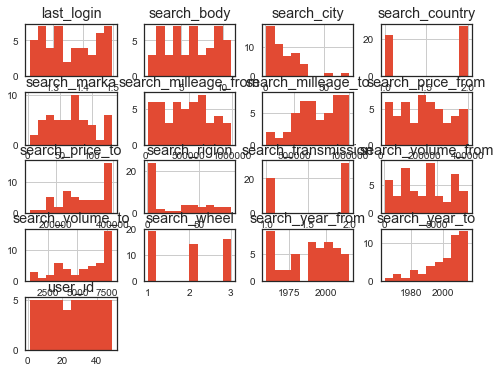

In [12]:
pandas.DataFrame.hist(dataframe)

In [57]:
Y_pred_rnd = round(Y_pred)

TypeError: type numpy.ndarray doesn't define __round__ method

In [16]:
dataframe.corr()

,last_login,search_body,search_country,search_marka,search_transmission,search_wheel,user_id,search_volume,search_milleage,search_price
last_login,1.000000,-0.115474,0.022384,-0.071284,-0.046494,-0.020060,-0.017998,NaN,NaN,NaN
search_body,-0.115474,1.000000,-0.001915,-0.055928,-0.049403,-0.033310,-0.036047,NaN,NaN,NaN
search_country,0.022384,-0.001915,1.000000,0.072432,-0.037934,-0.036925,-0.098124,NaN,NaN,NaN
search_marka,-0.071284,-0.055928,0.072432,1.000000,0.045894,-0.053708,0.038386,NaN,NaN,NaN
search_transmission,-0.046494,-0.049403,-0.037934,0.045894,1.000000,0.076887,0.042787,NaN,NaN,NaN
search_wheel,-0.020060,-0.033310,-0.036925,-0.053708,0.076887,1.000000,-0.021646,NaN,NaN,NaN
user_id,-0.017998,-0.036047,-0.098124,0.038386,0.042787,-0.021646,1.000000,NaN,NaN,NaN
search_volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
search_milleage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
search_price,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
dataframe.shape

(299, 20)